In [16]:
# Define if you want to download data from the original database or use the dataset one already provided and preprocessed
# Use:
# 'load': If you want to load the datase from the directory
# 'download': To download data from the database and process the images
dataset_load_method = 'load'

# Define if you want to save the dataset to a file
save_dataset = True

# Define if you want to load the trained classifiers from the directory
load_classifiers = True

# Define if you want to save the trained classifiers to a file
save_classifiers = True

# Define if you want to save classification test output to a file
save_results = True
if (save_results):
    result_output_file = open('result_output.txt','w') 

# Define if you want to print errors and warnings
enable_error_output = False

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import scipy
import sklearn
import pandas as pd
from sklearn import linear_model, datasets, metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import binarize
from sklearn.neural_network import BernoulliRBM, MLPClassifier
from sklearn.datasets import fetch_mldata
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from skimage import data, color, exposure, measure
from skimage.transform import resize
from skimage.feature import hog
from sklearn.manifold import TSNE
from sklearn.externals import joblib
import urllib
from io import StringIO
import cv2
from scipy import ndimage
from difflib import SequenceMatcher
from sys import stdout
from IPython.display import clear_output

In [18]:
def print_percentage(prct, msg=None):
    if (prct > 100 or prct < 0):
        return
    clear_output(wait=True)
    if (msg == None):
        stdout.write("Progress: [")
    else:
        stdout.write(msg+" [")
    end = int(int(prct)/10)
    for i in range(0, end):
        stdout.write("=")
    for i in range(end, 10):
        stdout.write(" ")
    stdout.write("] "+str(prct)+"%")
    stdout.flush()

In [19]:
df=pd.read_csv('first_and_last_names_fix.csv', sep=',',header=None)

In [20]:
print(df.head)

<bound method NDFrame.head of                 0                                                  1  \
0        _unit_id                                          image_url   
1       952459271  http://crl.checkbacksoon.nl/dls/dss/d2m/15/fir...   
2       952459272  http://crl.checkbacksoon.nl/dls/dss/d2m/15/fir...   
3       952459273  http://crl.checkbacksoon.nl/dls/dss/d2m/15/fir...   
4       952459274  http://crl.checkbacksoon.nl/dls/dss/d2m/15/fir...   
5       952459275  http://crl.checkbacksoon.nl/dls/dss/d2m/15/fir...   
6       952459276  http://crl.checkbacksoon.nl/dls/dss/d2m/15/fir...   
7       952459277  http://crl.checkbacksoon.nl/dls/dss/d2m/15/fir...   
8       952459278  http://crl.checkbacksoon.nl/dls/dss/d2m/15/fir...   
9       952459279  http://crl.checkbacksoon.nl/dls/dss/d2m/15/fir...   
10      952459280  http://crl.checkbacksoon.nl/dls/dss/d2m/15/fir...   
11      952459281  http://crl.checkbacksoon.nl/dls/dss/d2m/15/fir...   
12      952459282  http://crl.chec

In [28]:
def delborders(crop):
    cropf = ndimage.gaussian_filter(crop, 0.5)
    cropbin = (cropf<0.8)
    labeled, nr_objects = ndimage.label(cropbin)
    labels_to_delete = []
    for i in range(0, labeled.shape[1]):
        if (labeled[labeled.shape[0]-1][i] > 0):
            labels_to_delete.append(labeled[labeled.shape[0]-1][i])
    
    label_in_delete = False
    for x in range(0, labeled.shape[1]):
        for y in range(0, labeled.shape[0]):
            label_in_delete = False
            for l in range(0, len(labels_to_delete)):
                if (labeled[y][x] == labels_to_delete[l]):
                    label_in_delete = True
            
            if(label_in_delete):
                crop[y][x] = 1.0
    
    return crop

In [29]:
def getcrop(n):
    try: 
        urllib.request.urlretrieve(df[1][n], "temp.jpg")
    except urllib.error.URLError as e:
        return None, False
    img = cv2.imread('temp.jpg')
    imgh, imgw = img.shape[:-1]
    img_rgb = img.copy()
    template = cv2.imread('template.png')
    h, w = template.shape[:-1]

    template_match_success = False
    res = cv2.matchTemplate(img_rgb, template, cv2.TM_CCOEFF_NORMED)
    threshold = .7
    loc = np.where(res >= threshold)
    for pt in zip(*loc[::-1]):  # Switch collumns and rows
        cv2.rectangle(img_rgb, pt, (pt[0] + w, pt[1] + h), (0, 0, 255), 2)
        croph1 = pt[1]
        croph2 = pt[1]+h
        cropw = pt[0] + w
        template_match_success = True

    if (not template_match_success):
        #Template matching has failed so return...
        return img, False

    if (df[3][n] == 'first' or df[3][n] == 'last'):
        crop = img.copy()[max(croph1-6, 0):min(croph2+6, imgh), cropw:imgw]
    else:
        crop = img.copy()[max(min(croph2+4, imgh-1), 0):imgh, :]
        
    crop = color.rgb2gray(crop)
    if (df[3][n] == 'first_b' or df[3][n] == 'last_b'):
        crop = delborders(crop)
    return crop, True

In [30]:
def gen_dataset(n=df.shape[0]):
    data = []
    labels = []
    for i in range(1, n):
        crop, success = getcrop(i)
        if (success):
            data.append(crop)
            labels.append(df[2][i])
        else:
            if (enable_error_output):
                print("[WARNING] Template matching has failed for image: "+str(i))
        print_percentage((i*100/(n-1)), "Fetched "+str(i)+" images:")
    
    print_percentage(100, "Fetched "+str(n-1)+" images:")
    print("")
    print("Finished!")
    return data, labels

In [32]:
if (dataset_load_method == 'download'):
    dataset, labels = gen_dataset(10000)

# Load dataset from files
if (dataset_load_method == 'load'):
    dataset = np.load("HandwrittenNames_data.npz")['data']
    labels = np.load("HandwrittenNames_labels.npz")['data']
#If specified, the generated dataset can be saved to .npz files using these f

In [33]:
# Save dataset to a file if defined
if (save_dataset):
    np.savez("HandwrittenNames_data.npz", data=dataset)
    np.savez("HandwrittenNames_labels.npz", data=labels)

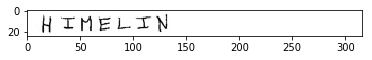

HIMELIN
<class 'numpy.str_'>


In [34]:

# Change selection to plot a different image and label# Chang 
selection = 0
plt.imshow(dataset[selection], cmap='gray')
plt.show()
print(labels[selection])
print(str(type(labels[0])))

In [35]:
def get_labels(crop):
    img = crop.copy() # gray-scale image

    # You could smooth the image (to remove small objects) but we saw better results without using it...
    # blur_radius = 0.5
    # imgf = ndimage.gaussian_filter(img, blur_radius)

    threshold = 0.8

    # Find connected components
    labeled, nr_objects = ndimage.label(img<threshold) 
    #print("Number of objects is " +str(nr_objects))

    return labeled, nr_objects


In [37]:
def get_bboxes(labeled, nr_objects):
    bboxes = np.zeros((nr_objects, 2, 2), dtype='int')

    x1, y1, x2, y2 = 0, labeled.shape[0], 0, 0
    coord = 0
    cont = 0
    ytop, ybot = 0, 0
    nzero, firstb = False, False

    for x in range(0, labeled.shape[1]):
        nzero, firstb = False, False
        ytop, ybot = 0, 0
        for y in range(0, labeled.shape[0]):
            if (labeled[y][x] > 0):
                nzero = True
                if (not firstb):
                    ytop = y
                    firstb = True
                ybot = y

        if (nzero):
            if (ytop < y1):
                y1 = ytop
            if (ybot > y2):
                y2 = ybot
            if (coord == 0):
                x1 = x
                coord = 1
            elif (coord == 1):
                x2 = x
        elif ((not nzero) and (coord == 1)):
            bboxes[cont][0] = [x1, y1]
            bboxes[cont][1] = [x2, y2]
            cont += 1
            coord = 0
            x1, y1, x2, y2 = 0, labeled.shape[0], 0, 0

    bboxes = bboxes[0:cont]
    return bboxes, cont

In [38]:
def crop_characters(img, bboxes, n):
    characters = []
    for i in range(0, n):
        c = img.copy()[bboxes[i][0][1]:bboxes[i][1][1], bboxes[i][0][0]:bboxes[i][1][0]]
        if (c.shape[0] != 0 and c.shape[1] != 0):
            c = resize(c, (28, 28), mode='constant', cval=1.0, clip=True)
            characters.append((c<0.80).reshape(784))
    return characters, len(characters)


In [39]:
def labelsep(label):
    if (type(label) is str or type(label) is np.str_):
        decomposed_label = list(label)
        labels = []
        for i in range(0, len(decomposed_label)):
            if (decomposed_label[i] != ' '):
                labels.append(decomposed_label[i])
        return labels
    else:
        return []

In [40]:
def get_characters(image, label):
    labeled, nr_objects = get_labels(image)
    bboxes, n = get_bboxes(labeled, nr_objects)
    characters, n_chars = crop_characters(image, bboxes, n)
    labels = labelsep(label)
    return characters, labels[0:n_chars]

def get_characters_img_only(image):
    labeled, nr_objects = get_labels(image)
    bboxes, n = get_bboxes(labeled, nr_objects)
    characters, n_chars = crop_characters(image, bboxes, n)
    return characters

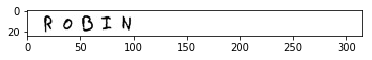

ROBIN


In [41]:
selection = 1
plt.imshow(dataset[selection], cmap='gray')
plt.show()
print(labels[selection])

In [48]:

characters,charlabels = get_characters(dataset[selection], labels[selection])

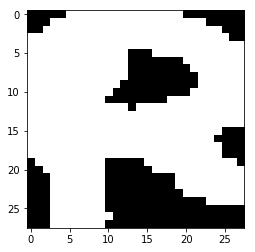

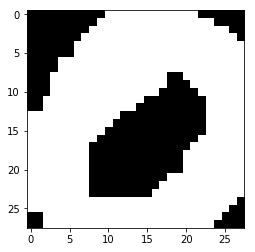

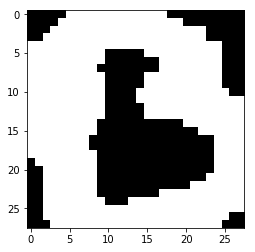

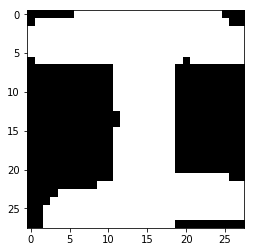

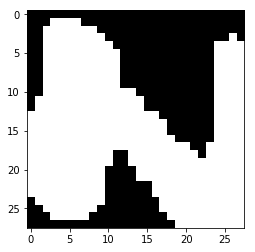

['R', 'O', 'B', 'I', 'N']


In [49]:
for i in range(0, len(characters)):
    plt.imshow(characters[i].reshape(28,28), cmap='gray')
    plt.show()
print(str(charlabels))

In [50]:
# Define if we want to print status of the training process
verbose_classifiers = True

In [52]:
# RBM Definition
rbm = BernoulliRBM(n_components=300, learning_rate=0.01, n_iter=45, random_state=0, verbose=verbose_classifiers)

# MLP Classifier Definition 
mlp = MLPClassifier(hidden_layer_sizes=(300,400,150), activation='relu', max_iter=5000, tol=0.0001, random_state=1, verbose=verbose_classifiers)

# We define the pipeline afterwards: MLP Classifier with RBM features
rbm_mlp_classifier = Pipeline(steps=[('rbm', rbm), ('mlp', mlp)])

In [53]:

# MLP Classifier with HOG (Histogram of Oriented Gradients) features# MLP C 
mlp_classifier_HOG = MLPClassifier(hidden_layer_sizes=(300,400,150), max_iter=5000, tol=0.001, random_state=1, verbose=verbose_classifiers)

In [54]:
# MLP Classifier with PCA (Principal Component Analisis) features
mlp_classifier_PCA = MLPClassifier(hidden_layer_sizes=(300,400,150), max_iter=5000, tol=0.0001, random_state=1, verbose=verbose_classifiers)

In [56]:
# MLP Only classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(300,400,150), max_iter=5000, tol=0.0001, random_state=1, verbose=verbose_classifiers)

In [57]:
X_train, X_test, Y_train, Y_test = train_test_split(dataset, labels, test_size=0.2, random_state=0)

In [59]:
print("Train batch lenghts:")
print("X_train size: "+str(len(X_train)))
print("Y_train size: "+str(len(Y_train)))
print("")
print("Test batch lenghts:")
print("X_test size: "+str(len(X_test)))
print("Y_test size: "+str(len(Y_test)))

Train batch lenghts:
X_train size: 7985
Y_train size: 7985

Test batch lenghts:
X_test size: 1997
Y_test size: 1997


In [61]:
X_train_chars = []
Y_train_chars = []
Train_with_inconsistencies = []
z = 0
for i in range(0, len(X_train)):
    print_percentage(i*100/len(X_train), "Processing train image "+ str(i)+" :")
    characters, charlabels = get_characters(X_train[i], Y_train[i])
    if (len(characters) != len(charlabels) or len(characters) == 0 or len(charlabels) == 0):
        if (enable_error_output):
            print("[Warning] Input number "+str(i)+" inconsistent! Skipping this one...")
        Train_with_inconsistencies.append(i)
        z += 1
    else:
        X_train_chars.extend(characters)
        Y_train_chars.extend(charlabels)

print_percentage(100, "Processing train image "+ str(len(X_train))+" :")
print("")
print(str(100-(z*100/len(X_train)))+"% of the data in train batch correctly extracted.")

Processing train image 7985 : [==========] 100%
94.16405760801503% of the data in train batch correctly extracted.


In [62]:
print("Character splitted train batch lenghts:")
print("X_train_chars size: "+str(len(X_train_chars)))
print("Y_train_chars size: "+str(len(Y_train_chars)))

Character splitted train batch lenghts:
X_train_chars size: 43802
Y_train_chars size: 43802


In [65]:
X_test_chars = []
Y_test_chars = []
Test_without_inconsistencies = []
z = 0
for i in range(0, len(X_test)):
    print_percentage(i*100/len(X_test), "Processing test image "+ str(i)+" :")
    characters, charlabels = get_characters(X_test[i], Y_test[i])
    if (len(characters) != len(charlabels) or len(characters) == 0 or len(charlabels) == 0):
        if (enable_error_output):
            print("[Warning] Input number "+str(i)+" inconsistent! Skipping this one...")
        z += 1
    else:
        X_test_chars.extend(characters)
        Y_test_chars.extend(charlabels)
        Test_without_inconsistencies.append(i)

print_percentage(100, "Processing train image "+ str(len(X_test))+" :")
print("")
print(str(100-(z*100/len(X_test)))+"% of the data in test batch correctly extracted.")

Processing train image 1997 : [==========] 100%
94.04106159238859% of the data in test batch correctly extracted.


In [66]:
print("Character splitted test batch lenghts:")
print("X_test_chars size: "+str(len(X_test_chars)))
print("Y_test_chars size: "+str(len(Y_test_chars)))

Character splitted test batch lenghts:
X_test_chars size: 11013
Y_test_chars size: 11013


In [67]:
# Calculate the Histogram of Oriented Gradients
fd_train = np.zeros((len(X_train_chars),392))
for i in range(0,len(X_train_chars)):
    print_percentage(i*100/len(X_train_chars), "Processing train image "+ str(i)+" :")
    fd_train[i], hog_image = hog(X_train_chars[i].reshape(28,28), orientations=8, pixels_per_cell=(4, 4), cells_per_block=(1, 1), visualise = True) 

print_percentage(100, "Processing train image "+ str(len(X_train_chars))+" :")

print("")
fd_test = np.zeros((len(X_test_chars),392))
for i in range(0,len(X_test_chars)):
    print_percentage(i*100/len(X_test_chars), "Processing test image "+ str(i)+" :")
    fd_test[i], hog_image = hog(X_test_chars[i].reshape(28,28), orientations=8, pixels_per_cell=(4, 4), cells_per_block=(1, 1), visualise = True) 
    
print_percentage(100, "Processing train image "+ str(len(X_test_chars))+" :")
print("")
print("Finished!")

Processing train image 11013 : [==========] 100%
Finished!


In [68]:
# We also define a function in case we need to transform something later
def HOG_transform(chars):
    fd_hog = np.zeros((len(chars),392))
    for i in range(0, len(chars)):
        fd_hog[i], hog_image = hog(chars[i].reshape(28,28), orientations=8, pixels_per_cell=(4, 4), cells_per_block=(1, 1), visualise = True)
    return fd_hog

# This function is for visualizing the HOG
def get_HOG_image(char):
    fd_hog = np.zeros((392))
    fd_hog, hog_image = hog(char.reshape(28,28), orientations=8, pixels_per_cell=(4, 4), cells_per_block=(1, 1), visualise = True)
    return hog_image

/Users/ritikaagarwal/anaconda/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation:

Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15

/Users/ritikaagarwal/anaconda/lib/python3.6/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning:

The 'box-forced' keyword argument is deprecated since 2.2.



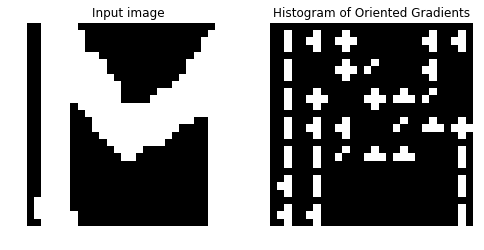

In [69]:
selection = 50

hog_image = get_HOG_image(X_train_chars[selection])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(X_train_chars[selection].reshape(28,28), cmap=plt.cm.gray)
ax1.set_title('Input image')
ax1.set_adjustable('box-forced')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 0.02))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
ax1.set_adjustable('box-forced')
plt.show()

In [70]:
#Transform the data to extract Principal Component Analysis features
# Standardising the values
Scaler = StandardScaler().fit(X_train_chars)
X_pca_train = Scaler.transform(X_train_chars)
# Call the PCA method with 100 components. 
pca = PCA(n_components=100)
pca.fit(X_pca_train)
P_train = pca.transform(X_pca_train)

# Standardising the values
X_pca_test = Scaler.transform(X_test_chars)

# Call the PCA method with 100 components. 
P_test = pca.transform(X_pca_test)

In [72]:

# We also define a function in case we need to transform something later# We al 
def PCA_transform(chars):
    # Standardising the values
    X_pca = Scaler.transform(chars)

    # Call the PCA method with 100 components. 
    P = pca.transform(X_pca)
    return P

In [73]:
print_limit = 1000
Target = Y_train_chars[:print_limit]
Target_colors = Y_train_chars[:print_limit]
for i in range(0, len(Target_colors)):
    Target_colors[i] = ord(Target_colors[i])
Characters = go.Scatter(
    x = P_train[:print_limit,0],
    y = P_train[:print_limit,1],
    name = Target,
    hoveron = Target,
    mode = 'markers',
    text = Target,
    showlegend = True,
    marker = dict(
        size = 8,
        color = Target_colors,
        colorscale ='Jet',
        showscale = False,
        line = dict(
            width = 2,
            color = 'rgb(255, 255, 255)'
        ),
        opacity = 0.8
    )
)
data = [Characters]

layout = go.Layout(
    title= 'Principal Component Analysis (PCA)',
    hovermode= 'closest',
    xaxis= dict(
         title= 'First Principal Component',
        ticklen= 5,
        zeroline= False,
        gridwidth= 2,
    ),
    yaxis=dict(
        title= 'Second Principal Component',
        ticklen= 5,
        gridwidth= 2,
    ),
    showlegend= True
)


fig = dict(data=data, layout=layout)
py.iplot(fig, filename='styled-scatter')

In [88]:
if(not load_classifiers):
    rbm_mlp_classifier.fit(X_train_chars[:], Y_train_chars)
else:
    rbm = joblib.load('RBM.pkl')
    mlp = joblib.load('MLP_withRBMfeatures.pkl')
    rbm_mlp_classifier = joblib.load('RBM_MLP_classifier.pkl')


In [86]:
import os
os.getcwd()
os.chdir('/Users/ritikaagarwal/Documents/handwrittendata/TrainedClassifiers/30000 images')


<Figure size 2016x2016 with 0 Axes>

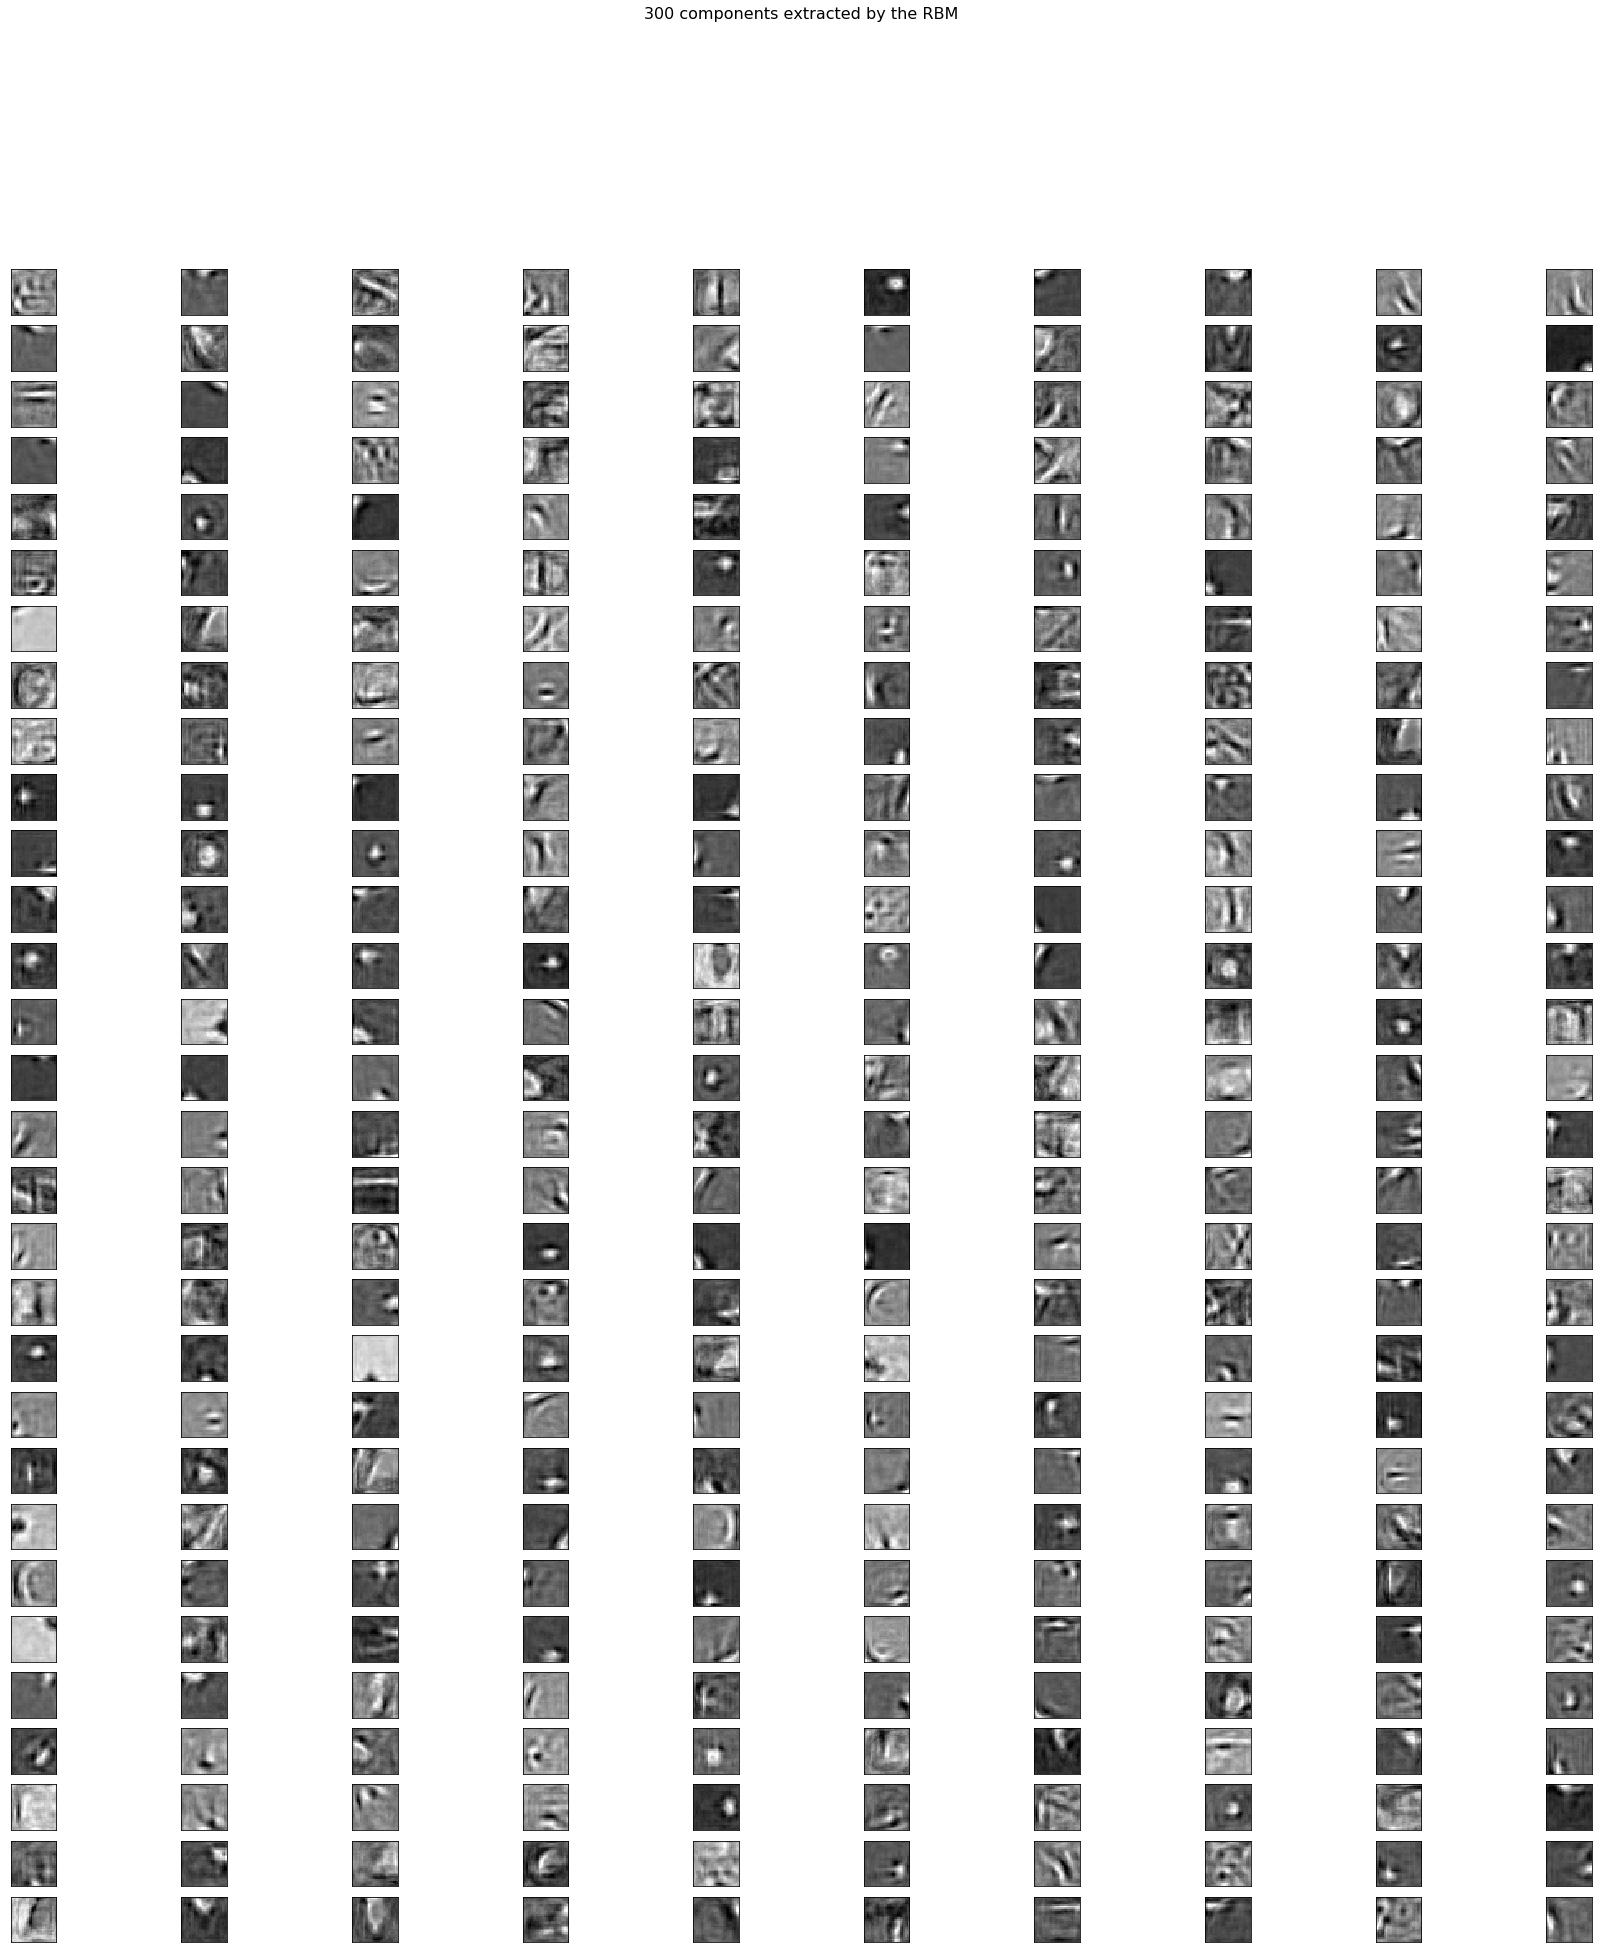

In [89]:
# We can define if we want to plot the components extracted by the RBM
plot_rbm_features = True

if (plot_rbm_features):
    plt.figure(figsize=(28, 28))
    for i, comp in enumerate(rbm.components_):
        plt.subplot(30, 10, i+1)
        plt.imshow(comp.reshape((28, 28)), cmap=plt.cm.gray_r, interpolation='nearest')
        plt.xticks(())
        plt.yticks(())
    plt.suptitle('300 components extracted by the RBM', fontsize=16)
    plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

    plt.show()

In [91]:

if(not load_classifiers):
    mlp_classifier_HOG.fit(fd_train,Y_train_chars)
else:
    mlp_classifier_HOG = joblib.load('MLP_HOG.pkl')

In [92]:
if (not load_classifiers):
    mlp_classifier_PCA.fit(P_train,Y_train_chars)
else:
    mlp_classifier_PCA = joblib.load('MLP_PCA.pkl')

In [93]:
if (not load_classifiers):
    mlp_classifier.fit(X_train_chars, Y_train_chars)
else:
    mlp_classifier = joblib.load('MLP.pkl')

In [94]:
#Saving the classifiers

# Save the classifiers if enabled:# Save  
if (save_classifiers):
    joblib.dump(rbm, 'RBM.pkl')
    joblib.dump(mlp, 'MLP_withRBMfeatures.pkl')
    joblib.dump(rbm_mlp_classifier, 'RBM_MLP_classifier.pkl')
    joblib.dump(mlp_classifier_HOG, 'MLP_HOG.pkl')
    joblib.dump(mlp_classifier_PCA, 'MLP_PCA.pkl')
    joblib.dump(mlp_classifier, 'MLP.pkl')


In [95]:
#Testing the results

def predict_full_name(name, classifier, transform=None):
    characters = get_characters_img_only(name)
    if (transform == 'hog'):
        prediction = classifier.predict(HOG_transform(characters))
    elif (transform == 'pca'):
        prediction = classifier.predict(PCA_transform(characters))
    else:
        prediction = classifier.predict(characters)
    strg = ''
    for i in range(0, len(prediction)):
        strg = strg+prediction[i]
    return strg


In [96]:
def predict_full_names(classifier, transform=None):
    correlation=0.0
    correct = 0
    for i in range(0,len(Test_without_inconsistencies)):
        predicted_name = predict_full_name(X_test[Test_without_inconsistencies[i]], classifier, transform)
        if (predicted_name == Y_test[Test_without_inconsistencies[i]]):
            correct += 1
        correlation += similar(predicted_name, Y_test[Test_without_inconsistencies[i]])
        print_percentage(i*100/len(X_test),"Making predictions "+str(i)+"/"+str(len(X_test))+":")
    print_percentage(100,"Making predictions "+str(len(X_test))+"/"+str(len(X_test))+":")
    return (correct/len(Test_without_inconsistencies)), (correlation/len(Test_without_inconsistencies))


In [97]:
def similar(a,b):
        return SequenceMatcher(None,a,b).ratio()

In [98]:
rbm_mlp_prediction = rbm_mlp_classifier.predict(X_test_chars)
mlp_prediction_HOG = mlp_classifier_HOG.predict(fd_test)
mlp_prediction_PCA = mlp_classifier_PCA.predict(P_test)
mlp_prediction = mlp_classifier.predict(X_test_chars)

In [99]:
print("MLP classification using RBM features:\n%s\n" % (metrics.classification_report(Y_test_chars, rbm_mlp_prediction)))
print("HOG + MLP classification:\n%s\n" % (metrics.classification_report(Y_test_chars, mlp_prediction_HOG)))
print("PCA + MLP classification:\n%s\n" % (metrics.classification_report(Y_test_chars, mlp_prediction_PCA)))
print("MLP only classification:\n%s\n" % (metrics.classification_report(Y_test_chars, mlp_prediction)))

if (save_results):
    result_output_file.write("MLP classification using RBM features:\n%s\n" % (metrics.classification_report(Y_test_chars, rbm_mlp_prediction)))
    result_output_file.write("\nHOG + MLP classification:\n%s\n" % (metrics.classification_report(Y_test_chars, mlp_prediction_HOG)))
    result_output_file.write("\nPCA + MLP classification:\n%s\n" % (metrics.classification_report(Y_test_chars, mlp_prediction_PCA)))
    result_output_file.write("\nMLP only classification:\n%s\n" % (metrics.classification_report(Y_test_chars, mlp_prediction)))

MLP classification using RBM features:
             precision    recall  f1-score   support

          -       0.94      0.71      0.81        24
          A       0.99      0.98      0.98      1686
          B       0.98      0.91      0.94        98
          C       0.98      0.96      0.97       305
          D       0.96      0.94      0.95       183
          E       0.98      0.98      0.98      1471
          F       0.94      0.80      0.87        61
          G       0.96      0.99      0.98       110
          H       0.94      0.94      0.94       327
          I       0.96      0.98      0.97       979
          J       0.99      0.95      0.97       109
          K       0.98      0.92      0.95        48
          L       0.98      0.99      0.99      1000
          M       0.97      0.97      0.97       571
          N       0.98      0.98      0.98      1060
          O       0.97      0.99      0.98       598
          P       0.97      0.98      0.97        93
      

In [100]:
correct_rbm_mlp, corr_rbm_mlp = predict_full_names(rbm_mlp_classifier)
correct_mlp_HOG, corr_mlp_HOG = predict_full_names(mlp_classifier_HOG, 'hog')
correct_mlp_PCA, corr_mlp_PCA = predict_full_names(mlp_classifier_PCA, 'pca')
correct_mlp, corr_mlp = predict_full_names(mlp_classifier)

Making predictions 1997/1997: [==========] 100%

In [102]:
print("Full name test results: ")
print("========================================================================")
print("| Classifier            | Correct percentage      | Correlation ratio  |")
print("========================================================================")
print("| MLP with RBM features | "+str(correct_rbm_mlp)+"     | "+str(corr_rbm_mlp)+" |")
print("========================================================================")
print("| MLP with HOG features | "+str(correct_mlp_HOG)+"     | "+str(corr_mlp_HOG)+" |")
print("========================================================================")
print("| MLP with PCA features | "+str(correct_mlp_PCA)+"     | "+str(corr_mlp_PCA)+" |")
print("========================================================================")
print("| MLP only              | "+str(correct_mlp)+"     | "+str(corr_mlp)+" |")
print("========================================================================")

if (save_results):
    result_output_file.write("\n\nFull name test results: ")
    result_output_file.write("\n========================================================================")
    result_output_file.write("\n| Classifier            | Correct percentage      | Correlation ratio  |")
    result_output_file.write("\n========================================================================")
    result_output_file.write("\n| MLP with RBM features | "+str(correct_rbm_mlp)+"     | "+str(corr_rbm_mlp)+" |")
    result_output_file.write("\n========================================================================")
    result_output_file.write("\n| MLP with HOG features | "+str(correct_mlp_HOG)+"     | "+str(corr_mlp_HOG)+" |")
    result_output_file.write("\n========================================================================")
    result_output_file.write("\n| MLP with PCA features | "+str(correct_mlp_PCA)+"     | "+str(corr_mlp_PCA)+" |")
    result_output_file.write("\n========================================================================")
    result_output_file.write("\n| MLP only              | "+str(correct_mlp)+"     | "+str(corr_mlp)+" |")
    result_output_file.write("\n========================================================================")

Full name test results: 
| Classifier            | Correct percentage      | Correlation ratio  |
| MLP with RBM features | 0.8706070287539937     | 0.9729299113781505 |
| MLP with HOG features | 0.8556975505857295     | 0.9675221181807894 |
| MLP with PCA features | 0.07294994675186368     | 0.6135721574328733 |
| MLP only              | 0.8690095846645367     | 0.9729125189281379 |


/Users/ritikaagarwal/anaconda/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation:

Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15



> Real label: BASTIEN
> Image:


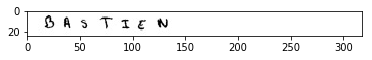

MLP with RBM features predicted: BASTIEN
MLP with HOG features predicted: BRATIEN
MLP with PCA features predicted: BMSIIIN
MLP predicted: BASTIEN



/Users/ritikaagarwal/anaconda/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation:

Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15



> Real label: MATTHIEU
> Image:


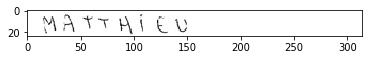

MLP with RBM features predicted: MATTHIEU
MLP with HOG features predicted: MATTHIEU
MLP with PCA features predicted: OITTECDU
MLP predicted: MATTHIEU



/Users/ritikaagarwal/anaconda/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation:

Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15



> Real label: TESSA
> Image:


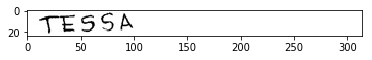

MLP with RBM features predicted: TESS
MLP with HOG features predicted: TESS
MLP with PCA features predicted: AGEA
MLP predicted: TESS



/Users/ritikaagarwal/anaconda/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation:

Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15



> Real label: AYMERIC
> Image:


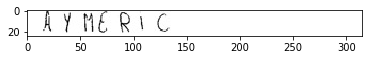

MLP with RBM features predicted: AYMERIC
MLP with HOG features predicted: AYMERIC
MLP with PCA features predicted: AYMERIC
MLP predicted: AYMERIC



/Users/ritikaagarwal/anaconda/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation:

Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15



> Real label: ELSA
> Image:


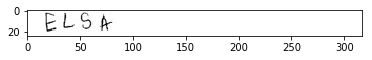

MLP with RBM features predicted: ELSA
MLP with HOG features predicted: ELSA
MLP with PCA features predicted: EEBA
MLP predicted: ELSA



In [103]:
indexes = [8, 10, 12, 14, 16]
for ind in indexes:
    rbm_mlp_predict = predict_full_name(X_test[ind], rbm_mlp_classifier)
    mlp_hog_predict = predict_full_name(X_test[ind], mlp_classifier_HOG, 'hog')
    mlp_pca_predict = predict_full_name(X_test[ind], mlp_classifier_PCA, 'pca')
    mlp_predict = predict_full_name(X_test[ind], mlp_classifier)
    print("> Real label: "+Y_test[ind])
    print("> Image:")
    plt.imshow(X_test[ind], cmap='gray')
    plt.show()
    print("MLP with RBM features predicted: "+rbm_mlp_predict)
    print("MLP with HOG features predicted: "+mlp_hog_predict)
    print("MLP with PCA features predicted: "+mlp_pca_predict)
    print("MLP predicted: "+mlp_predict)
    print("")
    
    if (save_results):
        result_output_file.write("\n\n> Real label: "+Y_test[ind])
        result_output_file.write("\nMLP with RBM features predicted: "+rbm_mlp_predict)
        result_output_file.write("\nMLP with HOG features predicted: "+mlp_hog_predict)
        result_output_file.write("\nMLP with PCA features predicted: "+mlp_pca_predict)
        result_output_file.write("\nMLP predicted: "+mlp_predict)
        result_output_file.write("\n")

In [104]:

if(save_results):
    result_output_file.close()